In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 49.5 MB/s eta 0:00:00


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/train_data.csv'
test_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/test_data.csv'

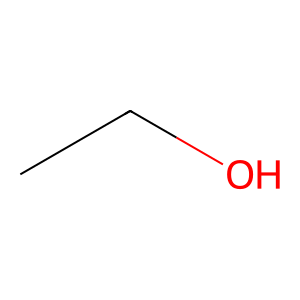

In [80]:
class MoleculeVisualizer():
    def visualize_molecule_2D(self,smiles):
        """
        Generates a 2D image of the molecule from its SMILES representation.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Invalid SMILES string.")
            return

        img = Draw.MolToImage(mol, size=(300, 300))

        return img

visualizer = MoleculeVisualizer()
visualizer.visualize_molecule_2D('CCO')

In [9]:
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

X_cols = ['sci_name','name','cid','smile','Molecular Weight','LogP','TPSA','Rotatable Bonds','H Bond Donors','H Bond Acceptors','Aromatic Rings','Num Rings','Atom Count','coulomb_matrix','embeddings']
y_cols = ['a', 'b']

X_train = train_data[X_cols]
y_train = train_data[y_cols]
X_test = test_data[X_cols]
y_test = test_data[y_cols]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 15) (165, 2) (55, 15) (55, 2)


In [56]:
train_imgs = []
test_imgs = []

for smile in X_train['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    train_imgs.append(np.array(img, dtype=np.float32))

for smile in X_test['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    test_imgs.append(np.array(img, dtype=np.float32))

train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

print(train_imgs.shape, test_imgs.shape)

[19:44:43] WARNING: not removing hydrogen atom without neighbors


(165, 300, 300, 3) (55, 300, 300, 3)


In [71]:
class EOSDataset(Dataset):

  def __init__(self, imgs, y):
    self.imgs = imgs
    self.y = y.values.astype(np.float32)
    self.transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    label = self.y[idx]

    img = self.transform(img)

    return img, label

  def transform(self, img):
    return self.transform(img)

In [ ]:
class CNN(nn.Module):

  def __init__(self, train_loader, test_loader):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    # Batch Normalization
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128 * 74 * 74, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.train_loader = train_loader
    self.test_loader = test_loader

    # Dropout for regularization
    self.dropout = nn.Dropout(0.3)

  # For training model on a and b and getting embedded vector for PKAN
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = F.relu(self.bn3(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)  # Regularization
    x = F.relu(self.fc2(x))
    return x

  # For training on a and b, not final output of model
  def predict(self, x):
    x = self.forward(x)
    x = F.relu(self.fc3(x))
    return x

  def train(self, train_loader, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    self.to(device)  # Move the model to the device (GPU if available)

    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data  # Get the inputs and labels from the data loader
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = self.predict(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss_history.append(loss.item())
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters

            running_loss += loss.item()  # Accumulate the loss for the epoch

        # Print the average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(train_loader):.4f}")

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    print("Training finished!")

    self.to(device)



In [73]:
train_dataset = EOSDataset(train_imgs, y_train)
test_dataset = EOSDataset(test_imgs, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [90]:
cnn = CNN(train_loader, test_loader)
cnn.train(train_loader, epochs=10, learning_rate=0.001)

torch.Size([32, 700928])
torch.Size([32, 700928])
torch.Size([32, 700928])
torch.Size([32, 700928])
torch.Size([32, 700928])


KeyboardInterrupt: 